# Road Traffic Accidents in Switzerland

Our project goal is to scrap all traffic accidents from the accidents map from http://map.donneesaccidents.ch/

## Data scraping strategy

Accessing http://map.donneesaccidents.ch/, wich redirects to : <br>
https://map.geo.admin.ch/?topic=vu&lang=fr&bgLayer=ch.swisstopo.pixelkarte-grau&layers=ch.astra.unfaelle-personenschaeden_alle&layers_timestamp=&catalogNodes=1318


Postman parses the following parameters : 
<code>
topic:vu
lang:en
bgLayer:ch.swisstopo.pixelkarte-grau
layers:ch.astra.unfaelle-personenschaeden_alle
layers_timestamp:
catalogNodes:1318
</code>

The most important one is layers:ch.astra.unfaelle-personenschaeden_alle.<br>
It is the layer that contains all the geo-information dots on "Accidents with personal injury" which is the selected data layer.
<img src="layer_selector.png">

Selection all kinds of accidents returns the following :<br>
<img src="layer_selector_all.png">
with layer parameters :<br>
layers:<br>
    &nbsp;ch.astra.unfaelle-personenschaeden_alle,<br>
    &nbsp;ch.astra.unfaelle-personenschaeden_getoetete,<br>
    &nbsp;ch.astra.unfaelle-personenschaeden_fussgaenger,<br>
    &nbsp;ch.astra.unfaelle-personenschaeden_fahrraeder,<br>
    &nbsp;ch.astra.unfaelle-personenschaeden_motorraeder<br>
layers_timestamp:,,,,<br>

Now we want every data for each layer. By selecting a dot on the map, it queries the related data to the server.
What we want to do is selecting all the entries in the map to retrieves all data. This is done by ctrl clicking the whole area.

This makes a query for each "layers" parameter :
<code>
geometry:443999.04209536605,39001.6733318335,870499.0420953662,303001.67333183356
geometryFormat:geojson
geometryType:esriGeometryEnvelope
imageDisplay:1536,759,96
lang:en
layers:all:<i>LAYER_PARAM</i>
mapExtent:269999.04209536605,9501.673331833561,1037999.042095366,389001.67333183356
returnGeometry:true
tolerance:5
</code><br>
But doesn't select all dots on map, so let's try the "load more results" button on a 'accidetns with fatalities' layer, we get :
<code>
geometry:443999.04209536605,39001.6733318335,870499.0420953662,303001.67333183356
geometryFormat:geojson
geometryType:esriGeometryEnvelope
imageDisplay:1536,759,96
lang:en
layers:all:ch.astra.unfaelle-personenschaeden_getoetete
mapExtent:136199.04209536605,-28148.32666816644,1134599.042095366,465201.67333183356
<b>offset:200</b>
returnGeometry:true
tolerance:5
</code>
Pressing load more until no more possible give offset=1200 (for a total of 1337 objects) i.e it loads data entries 200 by 200

## JSON Data scraping

In [1]:
import requests
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from Scripts.helpers import *


import pprint
#from bs4 import BeautifulSoup

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
#import raw data
data = import_data(all_data = False)
type(data)

Processing layer : ch.astra.unfaelle-personenschaeden_alle
Layer processed : 201 records

Whole dataset processed : 201 records



list

In [4]:
#translate data from german
json_data_preprocessed = preprocess_data(data)

In [5]:
print("Data entry example after clean and reformat:\n")
#pp.pprint(json_data_clean[0])
if 'properties' in json_data_preprocessed[0]:
    print('hi')
json_data_preprocessed[0]

Data entry example after clean and reformat:



{'accidentday_fr': 'vendredi / 12h-13h / septembre 2013',
 'accidenttype_fr': 'accident impliquant des piétons',
 'accidenttypecode': 8,
 'accidentyear': 2013,
 'bbox': [705812.0, 232162.0, 705812.0, 232162.0],
 'canton': 'SG',
 'coordinates': [[705812.0, 232162.0]],
 'featureId': 'E7C1164820D1026CE0430A8394271261',
 'fsocommunecode': '3340',
 'geometryType': 'Feature',
 'id': 'E7C1164820D1026CE0430A8394271261',
 'label': 'Fussgängerunfall',
 'layerBodId': 'ch.astra.unfaelle-personenschaeden_alle',
 'layerName': 'Accidents avec dommages corporels',
 'roadtype_de': 'Nebenstrasse',
 'roadtype_fr': 'route secondaire',
 'roadtype_it': 'Strada secondaria',
 'roadtypecode': 433,
 'severitycategory_fr': 'accident avec blessés légers',
 'severitycategorycode': 'ULV',
 'type': 'Feature'}

In [6]:
df = pd.DataFrame.from_dict(json_data_preprocessed)
df.set_index('id', inplace=True)
df.head()

,accidentday_fr,accidenttype_fr,accidenttypecode,accidentyear,bbox,canton,coordinates,featureId,fsocommunecode,geometryType,label,layerBodId,layerName,roadtype_de,roadtype_fr,roadtype_it,roadtypecode,severitycategory_fr,severitycategorycode,type
id,,,,,,,,,,,,,,,,,,,,
E7C1164820D1026CE0430A8394271261,vendredi / 12h-13h / septembre 2013,accident impliquant des piétons,8,2013,"[705812.0, 232162.0, 705812.0, 232162.0]",SG,"[[705812.0, 232162.0]]",E7C1164820D1026CE0430A8394271261,3340,Feature,Fussgängerunfall,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,Nebenstrasse,route secondaire,Strada secondaria,433,accident avec blessés légers,ULV,Feature
E7D2B416CFE90026E0430A8394278A4B,vendredi / 23h-00h / septembre 2013,accident en quittant une route,3,2013,"[627642.0, 241257.0, 627642.0, 241257.0]",SO,"[[627642.0, 241257.0]]",E7D2B416CFE90026E0430A8394278A4B,2401,Feature,Abbiegeunfall,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,Hauptstrasse,route principale,Strada principale,432,accident avec blessés légers,ULV,Feature
E7E3FBBEAA1E0192E0430A8394272005,vendredi / 07h-08h / septembre 2013,dérapage ou perte de maîtrise,0,2013,"[612312.0, 265695.0, 612312.0, 265695.0]",BS,"[[612312.0, 265695.0]]",E7E3FBBEAA1E0192E0430A8394272005,2701,Feature,Schleuder- oder Selbstunfall,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,Nebenstrasse,route secondaire,Strada secondaria,433,accident avec blessés graves,USV,Feature
E80E79B04BB60174E0430A839427D8F3,vendredi / 17h-18h / septembre 2013,accident en s'engageant sur une route,4,2013,"[639596.0, 215393.0, 639596.0, 215393.0]",LU,"[[639596.0, 215393.0]]",E80E79B04BB60174E0430A839427D8F3,1132,Feature,Einbiegeunfall,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,Nebenstrasse,route secondaire,Strada secondaria,433,accident avec blessés graves,USV,Feature
E838543221E4014EE0430A839427E3DE,vendredi / 09h-10h / septembre 2013,accident en quittant une route,3,2013,"[494559.0, 119517.0, 494559.0, 119517.0]",GE,"[[494559.0, 119517.0]]",E838543221E4014EE0430A839427E3DE,6630,Feature,Abbiegeunfall,ch.astra.unfaelle-personenschaeden_alle,Accidents avec dommages corporels,Hauptstrasse,route principale,Strada principale,432,accident avec blessés légers,ULV,Feature


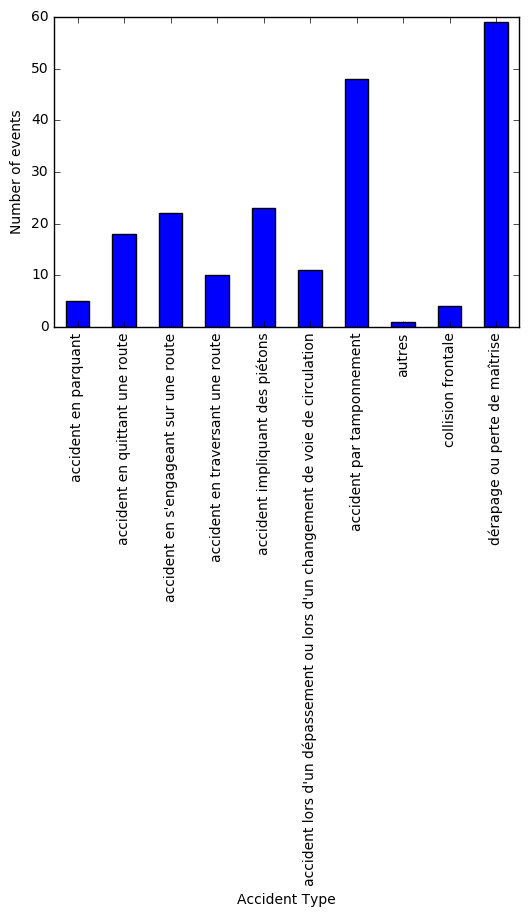

In [7]:
accident_type_stats = (df.groupby('accidenttype_fr').count())['accidentday_fr']
accident_type_stats.plot(kind='bar', stacked=True)
plt.xlabel("Accident Type")
plt.ylabel("Number of events")
plt.show()

# Data analysis

1) Accidents par rapport au temps<br>
2) Corrélation nombre/type d'accident avec les endroits (Valais ivresse)<br>
3) Tracker des anomalies (fin/début d'une série d'accident) et essayer d'en trouver la cause<br>